In [1]:
import os
import scipy.io
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis, entropy
import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)
from itertools import cycle
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import neurokit2 as nk
import warnings
import math



In [2]:
# Define paths
base_path = r"C:\Users\likhi\OneDrive\af-classification-from-a-short-single-lead-ecg-recording-the-physionet-computing-in-cardiology-challenge-2017-1.0.0"
extracted_training_path = os.path.join(base_path, "extracted_training2017", "training2017")
labels_path = os.path.join(base_path, "REFERENCE-v3.csv")

In [3]:
def load_ecg_signal(file_path):
    mat_data = scipy.io.loadmat(file_path)
    return mat_data["val"][0]

def filter_signal(signal, sampling_rate=300):
    lowcut = 0.5  # Hz
    highcut = 50.0  # Hz
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return filtfilt(b, a, signal)

def zscore_normalization(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def correct_inverted_signal(signal):
    """Correct inverted ECG signals based on polarity and peak characteristics."""
    if np.abs(np.min(signal)) > np.abs(np.max(signal)):
        signal = -signal
    return signal

def sliding_window(signal, window_size, step_size):
    windows = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        windows.append(signal[start:start + window_size])
    return windows


In [4]:
def calculate_poincare(rr_intervals):
    """Calculate Poincare SD1 and SD2 manually."""
    if len(rr_intervals) < 2:
        return 0, 0, 0
    diff_rr = np.diff(rr_intervals)
    sd1 = np.sqrt(np.var(diff_rr) / 2)
    sd2 = np.sqrt(2 * np.var(rr_intervals) - sd1**2)
    poincare_ratio = sd1 / sd2 if sd2 != 0 else 0
    return sd1, sd2, poincare_ratio

def extract_features(signal, sampling_rate=300):
    """Extract meaningful features from the ECG signal."""
    rpeaks = nk.ecg_findpeaks(signal, sampling_rate=sampling_rate)["ECG_R_Peaks"]
    rr_intervals = np.diff(rpeaks) / sampling_rate  # in seconds
    
    # Statistical features
    mean_rr = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    sdnn = np.std(rr_intervals) if len(rr_intervals) > 0 else 0
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 1 else 0
    mean = np.abs(np.mean(signal))  # Absolute mean to avoid negative polarity
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    
    # Frequency domain features
    power_spectrum = np.abs(np.fft.rfft(signal))**2
    freqs = np.fft.rfftfreq(len(signal), d=1/sampling_rate)
    dominant_freq = freqs[np.argmax(power_spectrum)]
    total_power = np.sum(power_spectrum)
    
    # Poincare features
    sd1, sd2, poincare_ratio = calculate_poincare(rr_intervals)
    
    # Amplitude and signal-related features
    max_amplitude = np.max(signal)
    mean_amplitude = np.mean(signal)
    amplitude_sd = np.std(signal)
    signal_entropy = entropy(np.abs(signal))
    signal_energy = np.sum(signal**2)
    
    # Return feature dictionary
    return {
        "mean_rr": mean_rr,
        "sdnn": sdnn,
        "rmssd": rmssd,
        "mean": mean,
        "std_dev": std_dev,
        "skewness": skewness,
        "kurtosis": kurt,
        "dominant_freq": dominant_freq,
        "total_power": total_power,
        "poincare_sd1": sd1,
        "poincare_sd2": sd2,
        "poincare_ratio": poincare_ratio,
        "max_amplitude": max_amplitude,
        "mean_amplitude": mean_amplitude,
        "amplitude_sd": amplitude_sd,
        "signal_entropy": signal_entropy,
        "signal_energy": signal_energy,
    }


In [6]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Preprocessing Parameters
sampling_rate = 300  # Hz
window_size = 3000  # 10 seconds at 300 Hz
step_size = 1500  # 5 seconds overlap

# Load labels
labels_df = pd.read_csv(labels_path, header=None, names=["record", "label"])

# Collect features
feature_data = []
processed_records = set()

for file_name in os.listdir(extracted_training_path):
    if file_name.endswith(".mat"):
        record_name = file_name.split(".")[0]
        
        if record_name in processed_records:
            continue
        
        label_row = labels_df[labels_df["record"] == record_name]
        if label_row.empty:
            continue
        label = label_row.iloc[0]["label"]
        
        file_path = os.path.join(extracted_training_path, file_name)
        ecg_signal = load_ecg_signal(file_path)
        filtered_signal = filter_signal(ecg_signal, sampling_rate=sampling_rate)
        normalized_signal = zscore_normalization(filtered_signal)
        corrected_signal = correct_inverted_signal(normalized_signal)
        
        segments = sliding_window(corrected_signal, window_size, step_size)
        for segment in segments:
            features = extract_features(segment, sampling_rate)
            features["label"] = label
            feature_data.append(features)
        
        processed_records.add(record_name)

# Create DataFrame
features_df = pd.DataFrame(feature_data)

# Save DataFrame
output_path = os.path.join(base_path, "features_data_simplified.csv")
features_df.to_csv(output_path, index=False)

print(f"Features extracted and saved to {output_path}")


Features extracted and saved to C:\Users\likhi\OneDrive\af-classification-from-a-short-single-lead-ecg-recording-the-physionet-computing-in-cardiology-challenge-2017-1.0.0\features_data_simplified.csv


In [23]:
features_df.head(10)

,mean_rr,sdnn,rmssd,mean,std_dev,skewness,kurtosis,dominant_freq,total_power,poincare_sd1,poincare_sd2,poincare_ratio,max_amplitude,mean_amplitude,amplitude_sd,signal_entropy,signal_energy,label
0,0.784722,0.030746,0.027816,0.012863,1.145227,1.715959,6.542878,2.5,5.903437e+06,0.018985,0.039117,0.485330,5.478928,-0.012863,1.145227,7.421790,3935.128430,N
1,0.792727,0.019788,0.021909,0.004314,1.032427,2.613354,9.391085,2.5,4.796746e+06,0.015312,0.023423,0.653685,5.478928,0.004314,1.032427,7.363615,3197.774819,N
2,0.765000,0.029234,0.022247,0.002247,0.913694,3.587445,14.606152,4.0,3.756815e+06,0.015520,0.038320,0.405008,5.512445,-0.002247,0.913694,7.337872,2504.528037,N
3,0.739231,0.016700,0.020435,0.010901,0.953118,3.520505,13.807951,2.7,4.089022e+06,0.014416,0.018707,0.770633,5.512445,0.010901,0.953118,7.307477,2725.658414,N
4,0.723846,0.042201,0.048743,0.015110,0.923699,3.595783,14.715419,4.1,3.841543e+06,0.033366,0.049483,0.674283,5.558456,0.015110,0.923699,7.318463,2560.343533,N
5,0.848485,0.255736,0.342343,0.014776,0.849555,3.795347,25.566251,0.9,3.249808e+06,0.241079,0.269597,0.894219,9.746492,0.014776,0.849555,7.470849,2165.883920,N
6,0.841212,0.256197,0.344537,0.027238,0.806535,4.271390,31.421459,1.0,2.933922e+06,0.243049,0.268703,0.904527,9.746492,-0.027238,0.806535,7.477177,1953.722281,N
7,0.887000,0.222638,0.306852,0.003324,1.166513,2.525098,11.522653,1.0,6.123486e+06,0.214289,0.230685,0.928927,8.697267,-0.003324,1.166513,7.384278,4082.289507,N
8,0.790000,0.250470,0.328195,0.023207,1.315260,2.491144,10.164114,1.1,7.789436e+06,0.232059,0.267617,0.867131,9.849216,0.023207,1.315260,7.371818,5191.341733,N
9,0.872667,0.218895,0.282926,0.011452,0.957677,3.710070,21.860396,4.1,4.128331e+06,0.200058,0.236235,0.846859,9.849216,-0.011452,0.957677,7.338277,2751.826573,N


In [24]:
features_df.tail(10)

,mean_rr,sdnn,rmssd,mean,std_dev,skewness,kurtosis,dominant_freq,total_power,poincare_sd1,poincare_sd2,poincare_ratio,max_amplitude,mean_amplitude,amplitude_sd,signal_entropy,signal_energy,label
46055,0.609286,0.013224,0.012943,0.041559,0.715984,0.724489,3.345350,0.9,2.322393e+06,0.009123,0.016326,0.558820,4.022235,-0.041559,0.715984,7.588493,1543.080797,N
46056,0.591333,0.066308,0.104319,0.002253,1.194587,2.172663,20.874393,1.3,6.421713e+06,0.073703,0.057978,1.271228,11.648585,-0.002253,1.194587,7.421683,4281.126892,N
46057,0.618222,0.162243,0.242827,0.028306,1.410988,1.347243,10.897837,1.2,8.966203e+06,0.171703,0.152195,1.128178,11.648585,0.028306,1.410988,7.500547,5975.065292,N
46058,0.645476,0.146886,0.227851,0.028195,1.000373,0.606999,5.315963,0.7,4.510516e+06,0.161101,0.131140,1.228461,5.556095,0.028195,1.000373,7.512921,3004.625792,N
46059,0.622667,0.028185,0.018366,0.013253,0.702692,0.995238,2.594892,0.7,2.223571e+06,0.012977,0.037687,0.344325,3.198815,0.013253,0.702692,7.619624,1481.853911,N
46060,0.970000,0.022662,0.031269,0.014835,1.065979,1.429136,4.654798,1.0,5.115383e+06,0.022111,0.023201,0.953025,6.040933,-0.014835,1.065979,7.582037,3409.594995,N
46061,0.971852,0.020068,0.028699,0.002148,0.917309,1.925789,8.053577,1.0,3.786595e+06,0.020188,0.019948,1.012012,5.168806,-0.002148,0.917309,7.551246,2524.382582,N
46062,0.943333,0.024140,0.027814,0.009081,0.898697,2.004171,8.466156,3.2,3.635195e+06,0.019488,0.028030,0.695258,5.168806,0.009081,0.898697,7.515948,2423.215671,N
46063,0.918667,0.021766,0.030082,0.017484,1.016190,1.174553,4.075094,1.1,4.649643e+06,0.021231,0.022289,0.952530,5.128969,0.017484,1.016190,7.556427,3098.844904,N
46064,0.905667,0.043895,0.038378,0.005754,1.027471,1.091636,3.528238,1.1,4.750934e+06,0.025542,0.056579,0.451444,5.128969,0.005754,1.027471,7.575383,3167.189334,N


In [20]:
features_df.isnull().sum()

mean_rr             0
sdnn                0
rmssd               0
mean                0
std_dev             0
skewness            0
kurtosis            0
dominant_freq       0
total_power         0
poincare_sd1        0
poincare_sd2      216
poincare_ratio    216
max_amplitude       0
mean_amplitude      0
amplitude_sd        0
signal_entropy      0
signal_energy       0
label               0
dtype: int64

In [25]:
# Select columns to impute 
columns_to_impute = [col for col in features_df.columns if col not in ['label']]

# Impute missing values in selected columns with the median
features_df[columns_to_impute] = features_df[columns_to_impute].fillna(features_df[columns_to_impute].median())

In [26]:
features_df.isnull().sum()

mean_rr           0
sdnn              0
rmssd             0
mean              0
std_dev           0
skewness          0
kurtosis          0
dominant_freq     0
total_power       0
poincare_sd1      0
poincare_sd2      0
poincare_ratio    0
max_amplitude     0
mean_amplitude    0
amplitude_sd      0
signal_entropy    0
signal_energy     0
label             0
dtype: int64

In [27]:
features_df.describe()

,mean_rr,sdnn,rmssd,mean,std_dev,skewness,kurtosis,dominant_freq,total_power,poincare_sd1,poincare_sd2,poincare_ratio,max_amplitude,mean_amplitude,amplitude_sd,signal_entropy,signal_energy
count,46065.000000,46065.000000,46065.000000,4.606500e+04,46065.000000,46065.000000,46065.000000,46065.000000,4.606500e+04,46065.000000,46065.000000,46065.000000,46065.000000,46065.000000,46065.000000,46065.000000,46065.000000
mean,0.831309,0.095116,0.130942,1.577874e-02,0.952350,1.629992,9.951815,2.659399,4.296689e+06,0.090727,0.093228,0.967610,5.206444,-0.001191,0.952350,7.485783,2862.867230
std,0.186133,0.126087,0.197238,1.678150e-02,0.216309,1.923260,8.791348,1.902189,1.919637e+06,0.131566,0.125571,1.181115,2.275522,0.023004,0.216309,0.144140,1279.216425
min,0.000000,0.000000,0.000000,6.246674e-07,0.069637,-7.466181,-0.868187,0.000000,2.263278e+04,0.000000,0.000000,0.000000,0.195668,-0.197728,0.069637,6.143504,14.818252
25%,0.725000,0.015287,0.015341,4.771827e-03,0.886974,0.527445,4.161038,1.100000,3.545823e+06,0.010448,0.017219,0.531458,3.974052,-0.012198,0.886974,7.409569,2362.281245
50%,0.826667,0.042484,0.045108,1.082144e-02,0.976075,1.846432,8.370625,2.400000,4.289743e+06,0.031080,0.045131,0.781952,5.359158,-0.001050,0.976075,7.511839,2858.982501
75%,0.930000,0.148084,0.202622,2.093790e-02,1.022602,3.052858,13.826371,3.800000,4.708762e+06,0.141382,0.129592,1.168151,6.265783,0.009431,1.022602,7.587034,3138.016967
max,9.453333,3.045000,6.090000,2.465119e-01,2.395286,15.251379,304.558629,25.000000,2.581891e+07,3.649850,4.306280,121.297451,31.718327,0.246512,2.395286,7.817044,17212.392303


In [28]:
features_df.shape

(46065, 18)

In [29]:
print(features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46065 entries, 0 to 46064
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mean_rr         46065 non-null  float64
 1   sdnn            46065 non-null  float64
 2   rmssd           46065 non-null  float64
 3   mean            46065 non-null  float64
 4   std_dev         46065 non-null  float64
 5   skewness        46065 non-null  float64
 6   kurtosis        46065 non-null  float64
 7   dominant_freq   46065 non-null  float64
 8   total_power     46065 non-null  float64
 9   poincare_sd1    46065 non-null  float64
 10  poincare_sd2    46065 non-null  float64
 11  poincare_ratio  46065 non-null  float64
 12  max_amplitude   46065 non-null  float64
 13  mean_amplitude  46065 non-null  float64
 14  amplitude_sd    46065 non-null  float64
 15  signal_entropy  46065 non-null  float64
 16  signal_energy   46065 non-null  float64
 17  label           46065 non-null 

In [30]:
print("\nLabel Distribution:")
print(features_df['label'].value_counts())


Label Distribution:
label
N    27039
O    13939
A     4075
~     1012
Name: count, dtype: int64


In [31]:
features_df = features_df.drop_duplicates(keep='first')

In [32]:
duplicate_count = features_df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 0


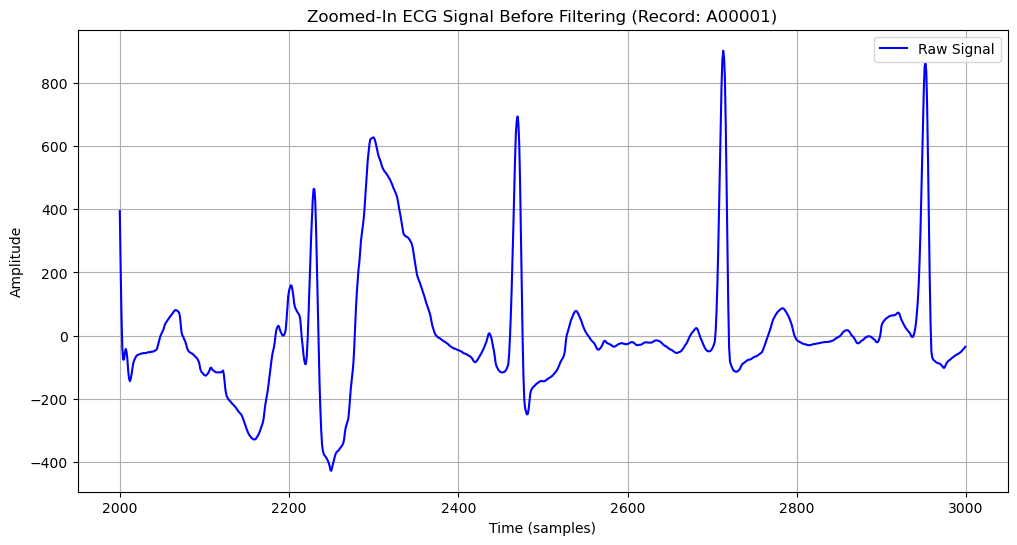

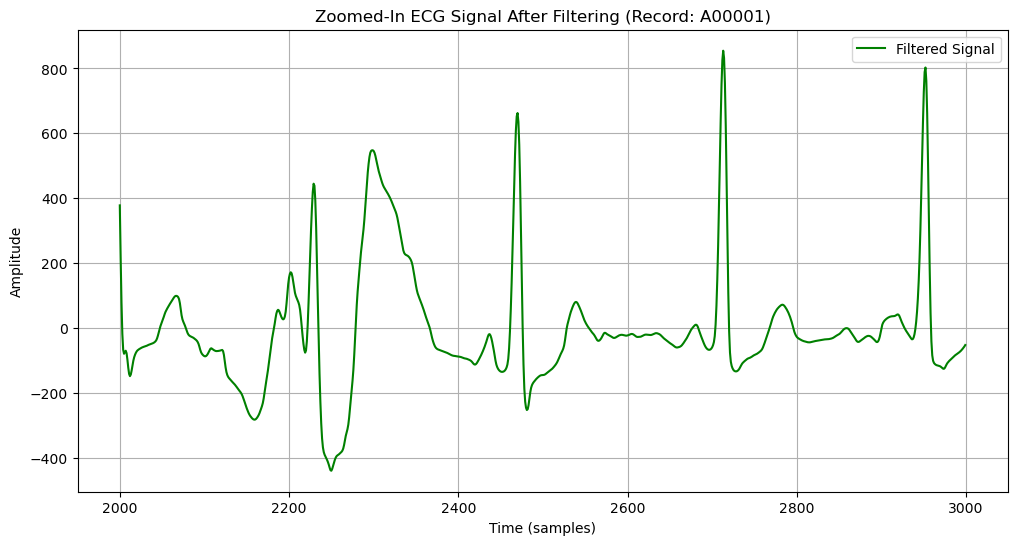

In [33]:
# Load the first record for visualization
record_name = labels_df.iloc[0]["record"]
file_path = os.path.join(extracted_training_path, f"{record_name}.mat")
ecg_signal = load_ecg_signal(file_path)
filtered_signal = filter_signal(ecg_signal, sampling_rate=sampling_rate)

# Select a zoomed segment for visualization
start_index = 2000
end_index = 3000

# Visualization: Raw ECG Signal
plt.figure(figsize=(12, 6))
plt.plot(range(start_index, end_index), ecg_signal[start_index:end_index], label="Raw Signal", color="blue")
plt.title(f"Zoomed-In ECG Signal Before Filtering (Record: {record_name})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Filtered ECG Signal
plt.figure(figsize=(12, 6))
plt.plot(range(start_index, end_index), filtered_signal[start_index:end_index], label="Filtered Signal", color="green")
plt.title(f"Zoomed-In ECG Signal After Filtering (Record: {record_name})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


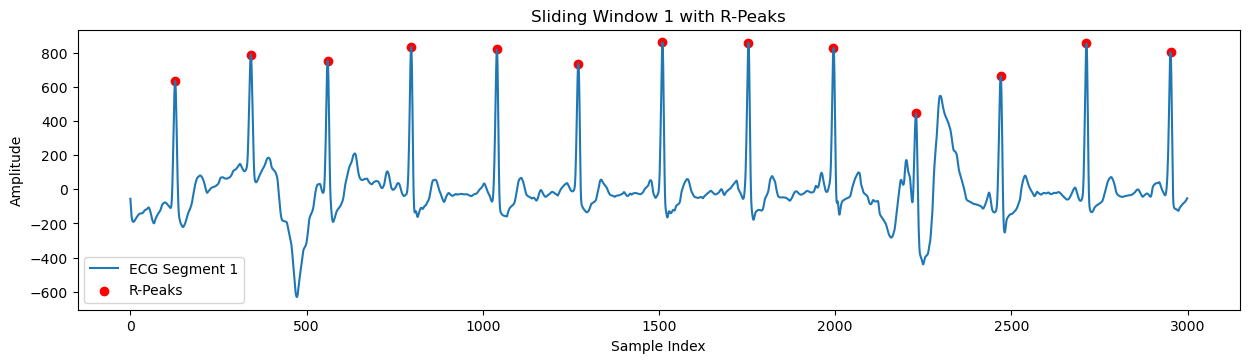

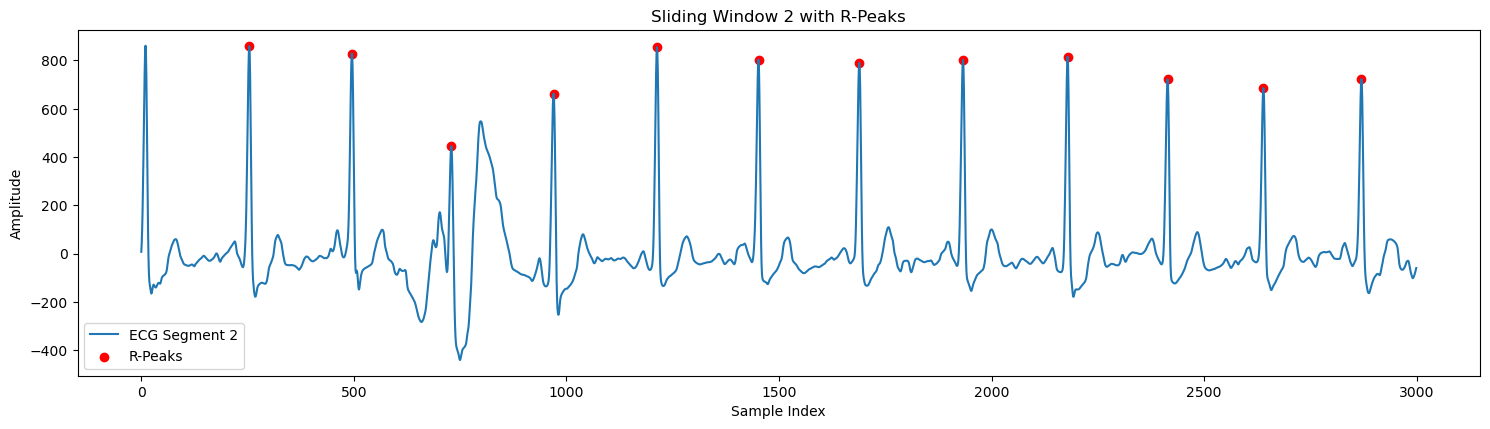

In [34]:
# Select two segments from the same record
segments = sliding_window(filtered_signal, window_size, step_size)
segment_1 = segments[0]  # First segment
segment_2 = segments[1]  # Second segment

# Detect R-peaks for both segments
ecg_peaks_1 = nk.ecg_peaks(segment_1, sampling_rate=sampling_rate)
ecg_peaks_2 = nk.ecg_peaks(segment_2, sampling_rate=sampling_rate)

rpeaks_1 = ecg_peaks_1[1]["ECG_R_Peaks"]
rpeaks_2 = ecg_peaks_2[1]["ECG_R_Peaks"]

# Plot the first segment with R-peaks
plt.figure(figsize=(15, 8))

# First segment
plt.subplot(2, 1, 1)
plt.plot(segment_1, label="ECG Segment 1")
plt.scatter(rpeaks_1, segment_1[rpeaks_1], color="red", label="R-Peaks")
plt.title("Sliding Window 1 with R-Peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()



# Plot the second segment with R-peaks
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(segment_2, label="ECG Segment 2")
plt.scatter(rpeaks_2, segment_2[rpeaks_2], color="red", label="R-Peaks")
plt.title("Sliding Window 2 with R-Peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()


plt.tight_layout()
plt.show()


In [36]:
# Display summary statistics
summary_statistics = features_df.describe()
print(summary_statistics)

            mean_rr          sdnn         rmssd          mean       std_dev  \
count  46055.000000  46055.000000  46055.000000  4.605500e+04  46055.000000   
mean       0.831308      0.095121      0.130947  1.578057e-02      0.952338   
std        0.186146      0.126099      0.197256  1.678247e-02      0.216330   
min        0.000000      0.000000      0.000000  6.246674e-07      0.069637   
25%        0.725000      0.015283      0.015331  4.773811e-03      0.886956   
50%        0.826667      0.042474      0.045092  1.082250e-02      0.976064   
75%        0.930000      0.148109      0.202622  2.093950e-02      1.022607   
max        9.453333      3.045000      6.090000  2.465119e-01      2.395286   

           skewness      kurtosis  dominant_freq   total_power  poincare_sd1  \
count  46055.000000  46055.000000   46055.000000  4.605500e+04  46055.000000   
mean       1.629843      9.952421       2.659396  4.296634e+06      0.090731   
std        1.923436      8.792144       1.902224

In [46]:
# Extract numeric columns 
numeric_columns = features_df.select_dtypes(include=[np.number]).columns.tolist()


if 'label' in numeric_columns:
    numeric_columns.remove('label')

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to all numeric columns
features_df[numeric_columns] = scaler.fit_transform(features_df[numeric_columns])

# Print the first few rows of the normalized DataFrame
print(features_df.head())


    mean_rr      sdnn     rmssd      mean   std_dev  skewness  kurtosis  \
0  0.083010  0.010097  0.004568  0.052176  0.462490  0.404187  0.024265   
1  0.083857  0.006498  0.003598  0.017498  0.413988  0.443689  0.033590   
2  0.080924  0.009601  0.003653  0.009114  0.362934  0.486567  0.050665   
3  0.078198  0.005484  0.003356  0.044218  0.379886  0.483621  0.048051   
4  0.076570  0.013859  0.008004  0.061292  0.367236  0.486934  0.051022   

   dominant_freq  total_power  poincare_sd1  poincare_sd2  poincare_ratio  \
0          0.100     0.227971      0.005202      0.009084        0.004001   
1          0.100     0.185070      0.004195      0.005439        0.005389   
2          0.160     0.144757      0.004252      0.008899        0.003339   
3          0.108     0.157635      0.003950      0.004344        0.006353   
4          0.164     0.148041      0.009142      0.011491        0.005559   

   max_amplitude  mean_amplitude  amplitude_sd  signal_entropy  signal_energy  \
0    

In [47]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column in the features DataFrame
features_df['label'] = label_encoder.fit_transform(features_df['label'])

# View the mapping of original labels to encoded numbers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the mapping
print("Label Encoding Mapping:")
print(label_mapping)


Label Encoding Mapping:
{'A': 0, 'N': 1, 'O': 2, '~': 3}


In [52]:
# Display summary statistics
summary_statistics = features_df.describe()
print(summary_statistics)

            mean_rr          sdnn         rmssd          mean       std_dev  \
count  46055.000000  46055.000000  46055.000000  46055.000000  46055.000000   
mean       0.087938      0.031238      0.021502      0.064013      0.379551   
std        0.019691      0.041412      0.032390      0.068080      0.093019   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.076693      0.005019      0.002517      0.019363      0.351437   
50%        0.087447      0.013949      0.007404      0.043900      0.389752   
75%        0.098378      0.048640      0.033271      0.084941      0.409765   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           skewness      kurtosis  dominant_freq   total_power  poincare_sd1  \
count  46055.000000  46055.000000   46055.000000  46055.000000  46055.000000   
mean       0.400396      0.035428       0.106376      0.165683      0.024859   
std        0.084667      0.028786       0.076089

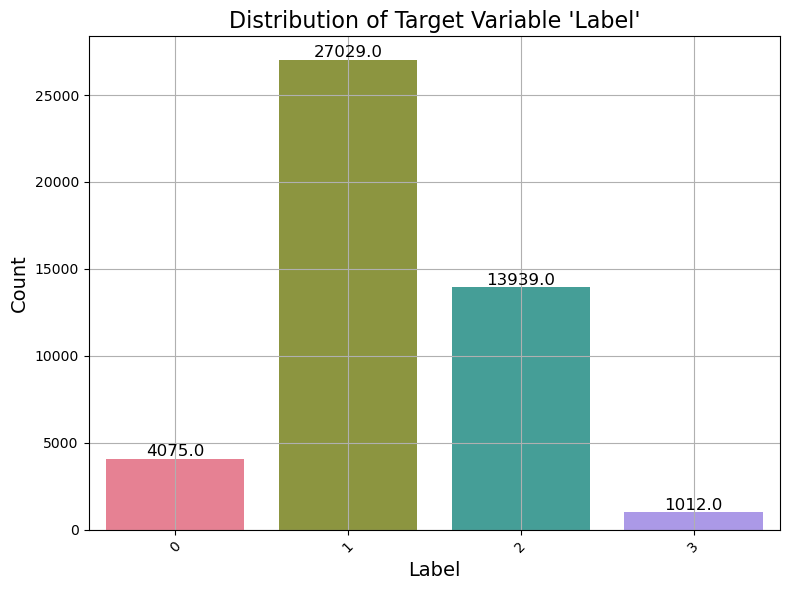

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="label", data=features_df, palette="husl")


for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')


plt.title("Distribution of Target Variable 'Label'", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()


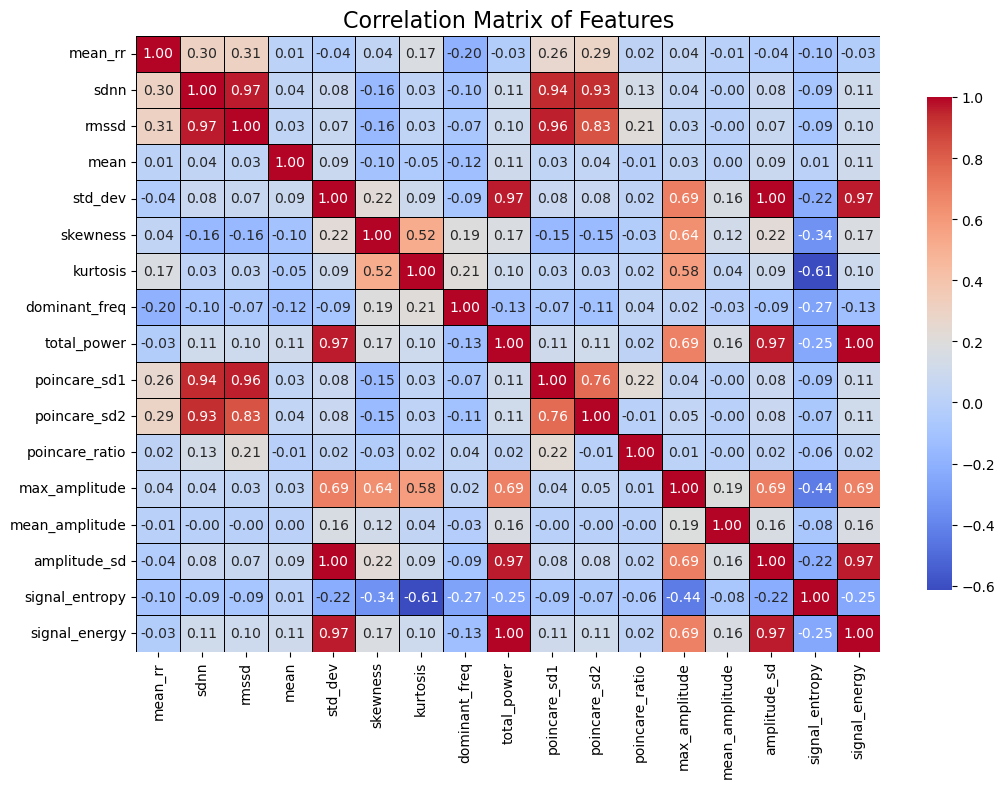

In [49]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = features_df.drop(columns=['label']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

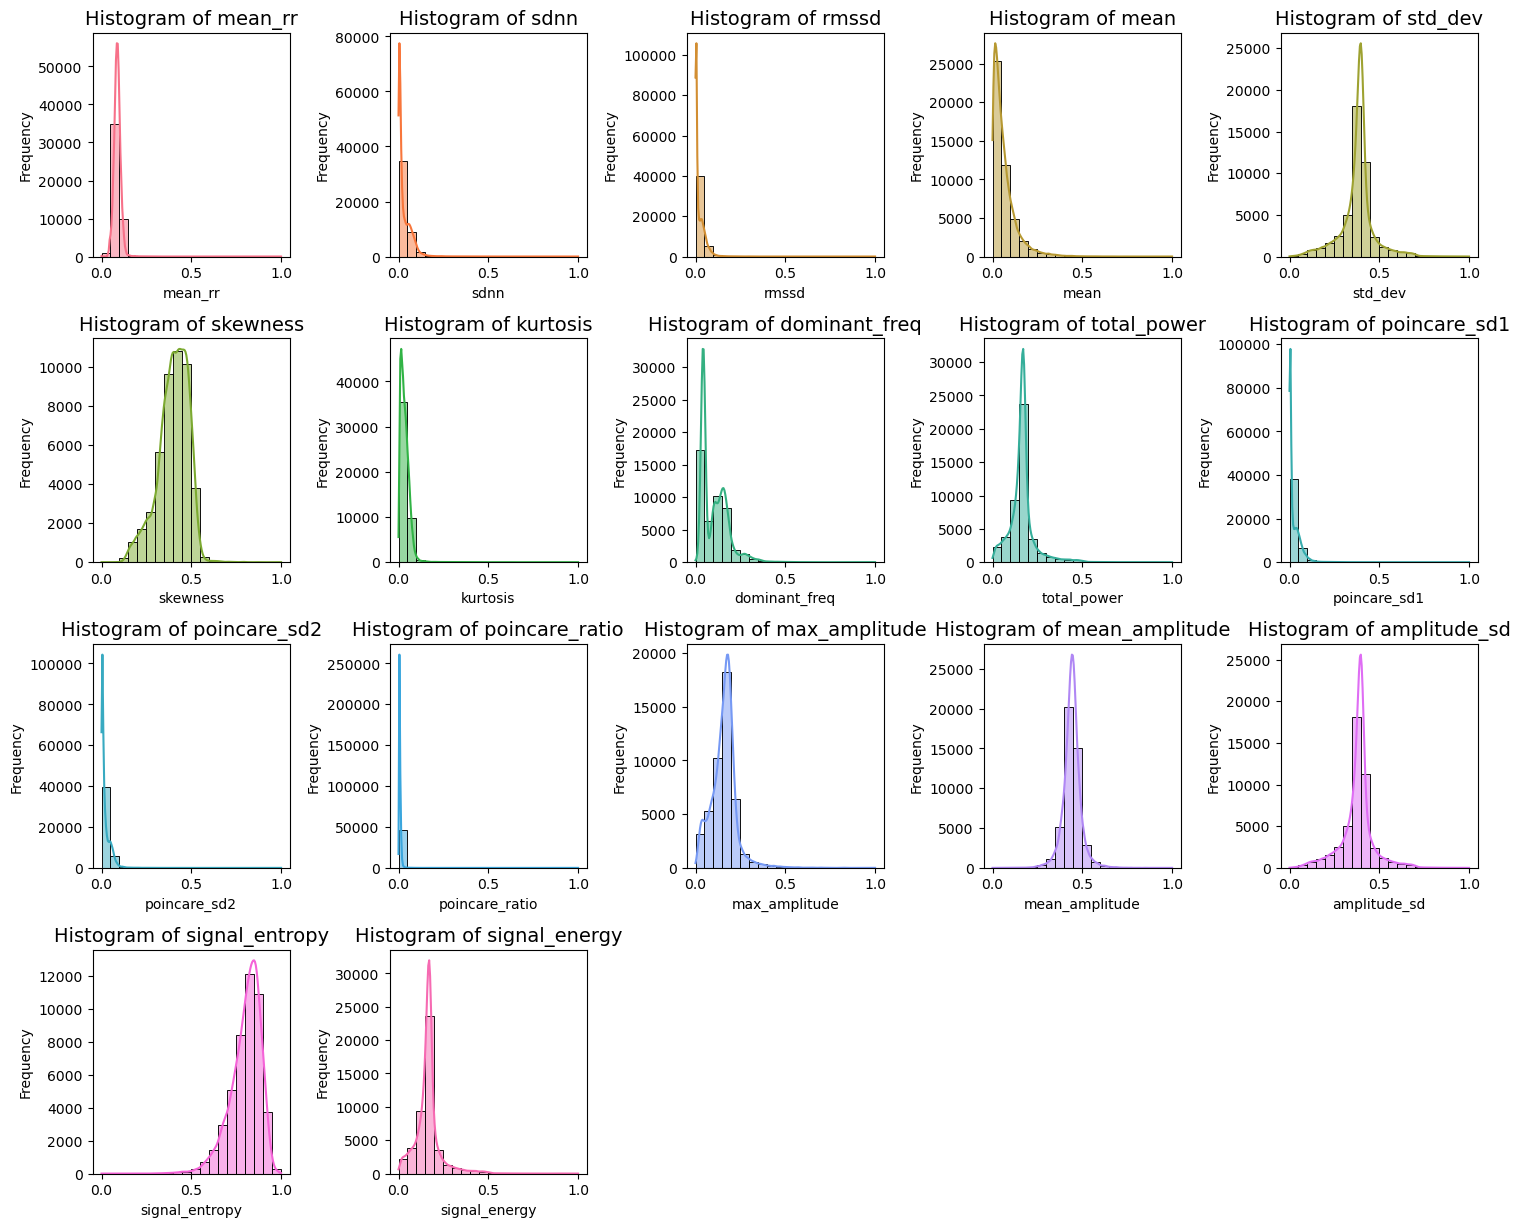

In [53]:
colors = sns.color_palette("husl", len(features_df.drop(columns=['label']).columns))

# Univariate Analysis - Histograms
plt.figure(figsize=(15, 15))
for i, column in enumerate(features_df.drop(columns=['label']).columns):
    plt.subplot(5, 5, i + 1)  
    sns.histplot(features_df[column], bins=20, kde=True, color=colors[i])
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

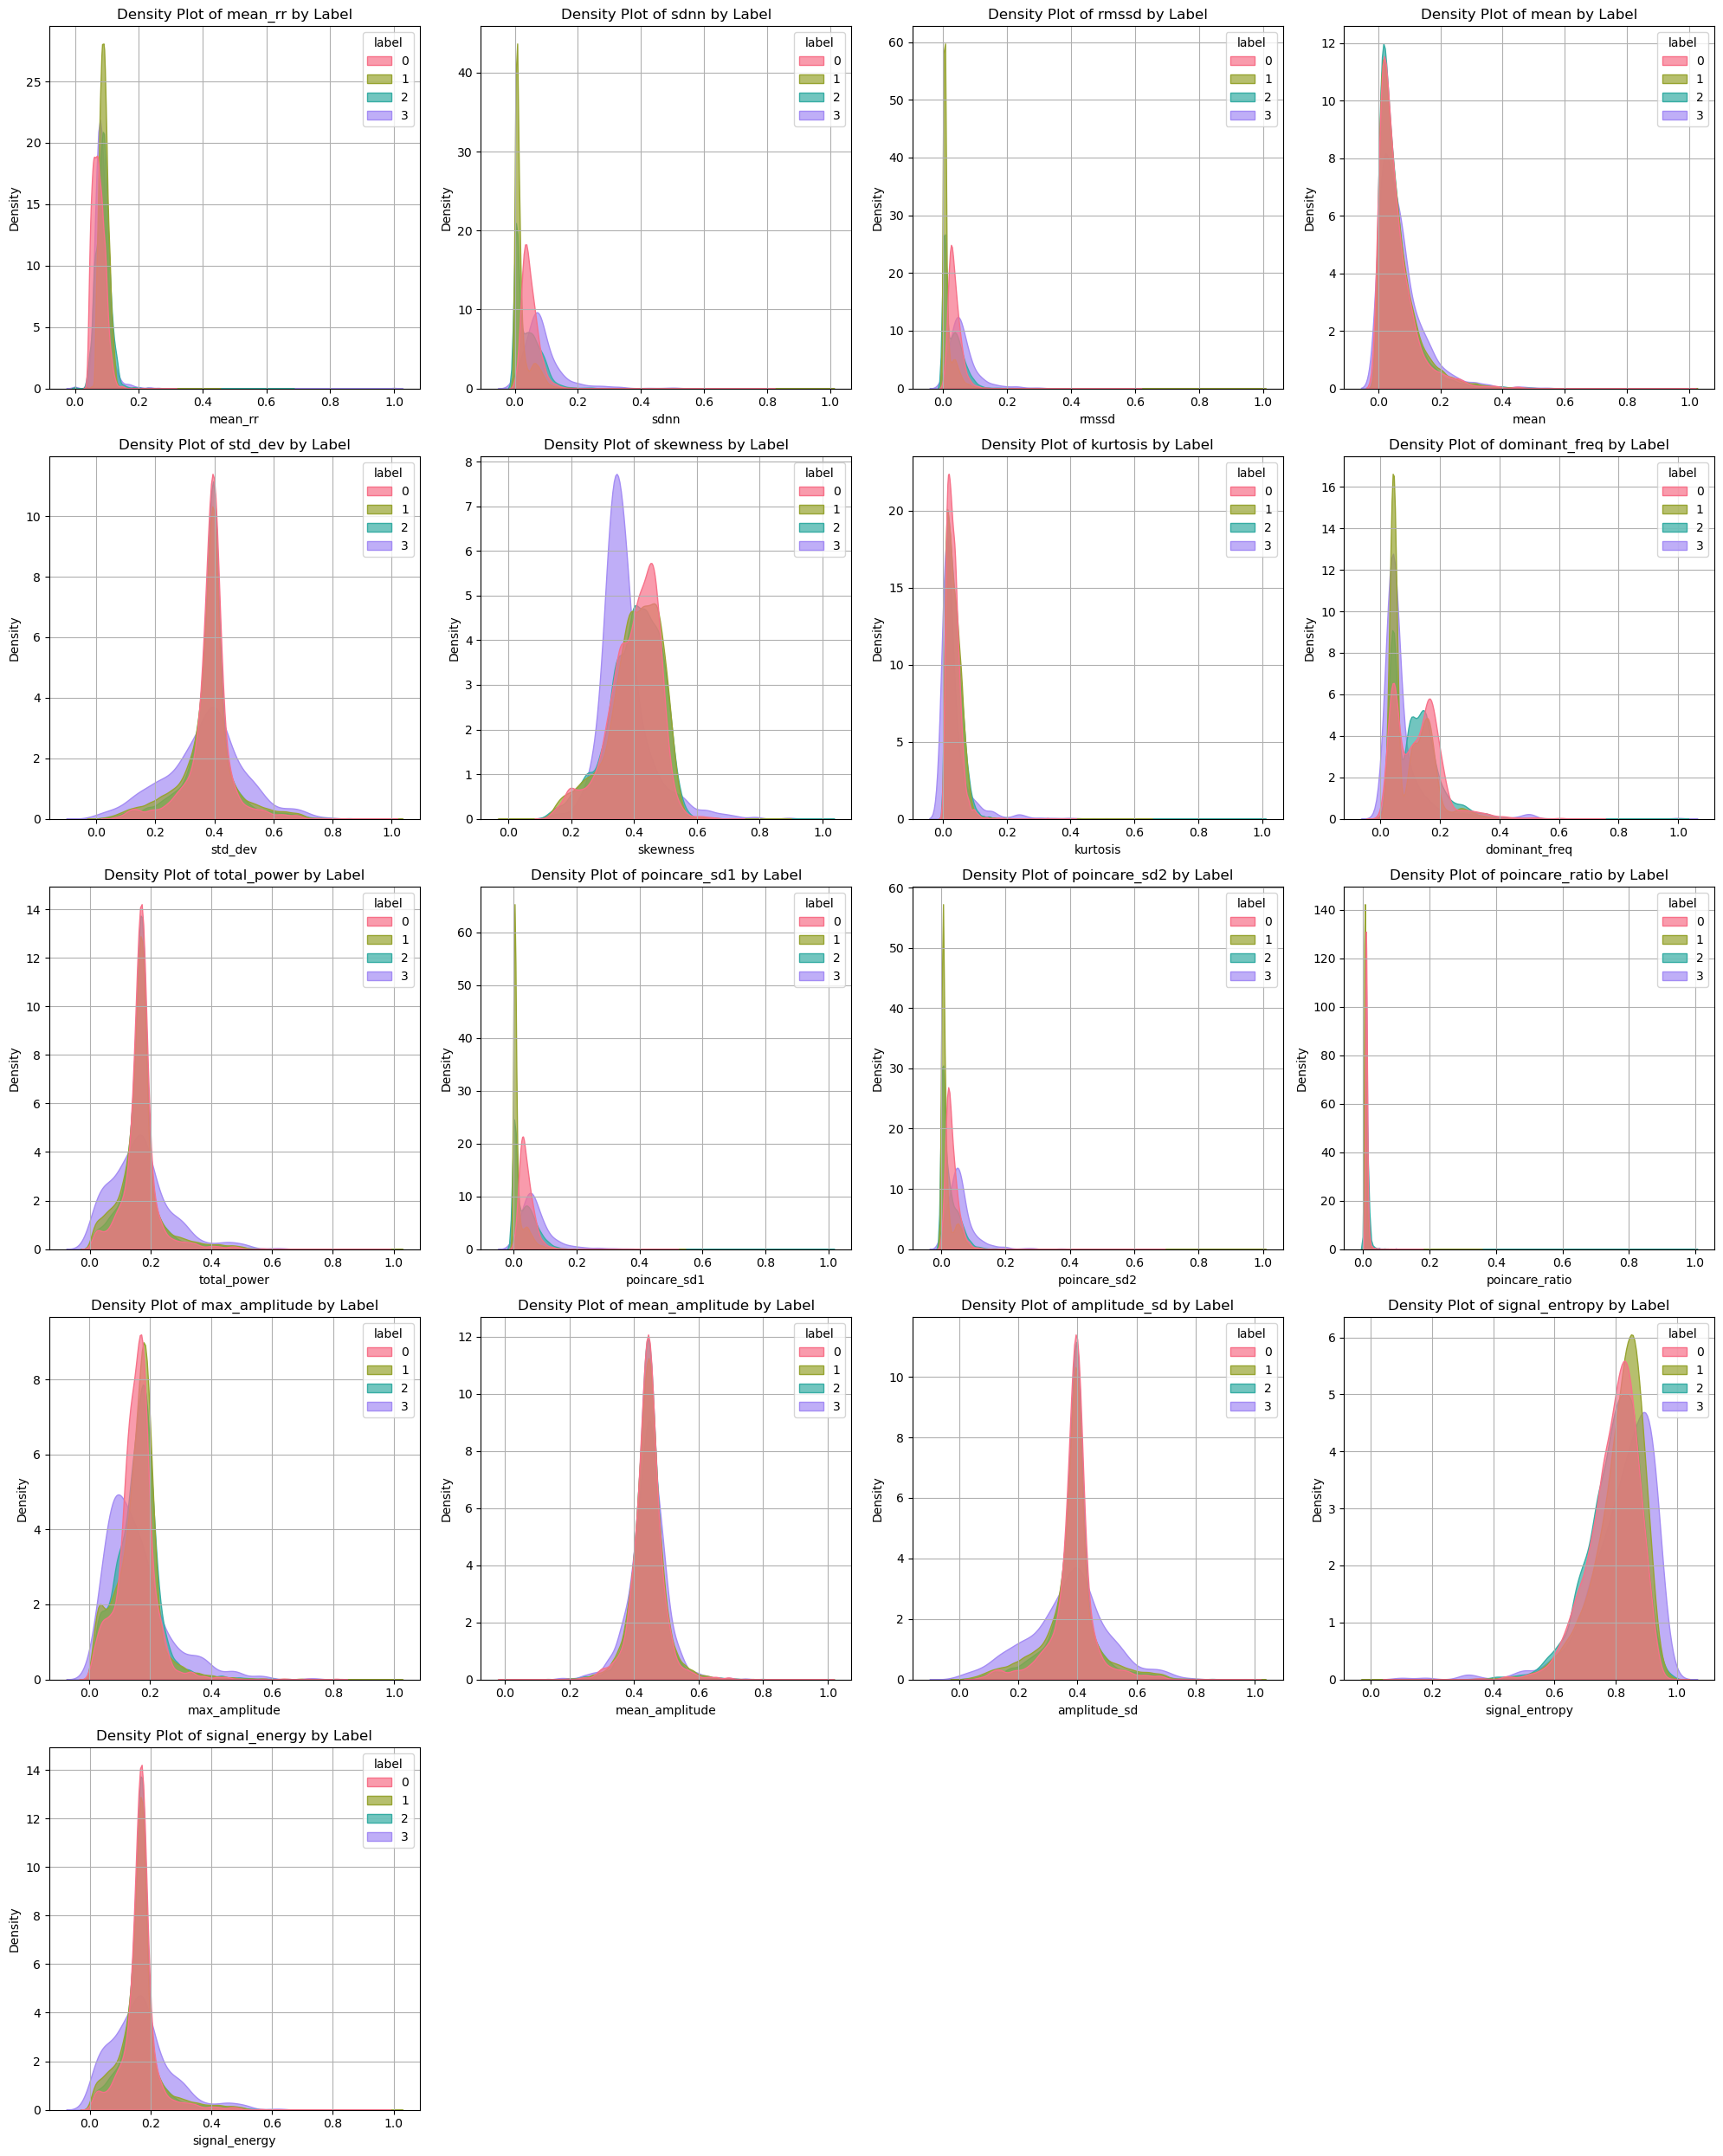

In [65]:
# Define numeric columns 
numeric_columns = features_df.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_columns:
    numeric_columns.remove('label')


palette = sns.color_palette("husl", len(features_df['label'].unique()))


num_plots = len(numeric_columns)
rows = 5
cols = math.ceil(num_plots / rows)

# Plot density plots for each numeric variable
plt.figure(figsize=(cols * 5, rows * 5))

for i, col in enumerate(numeric_columns):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(
        data=features_df, 
        x=col, 
        hue="label", 
        fill=True, 
        common_norm=False, 
        alpha=0.7, 
        palette=palette
    )
    plt.title(f"Density Plot of {col} by Label", fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Density", fontsize=10)
    plt.grid(True)

plt.tight_layout()
plt.show()


Shape of Training Features (X_train): (36844, 17)
Shape of Training Labels (y_train): (36844,)
Shape of Testing Features (X_test): (9211, 17)
Shape of Testing Labels (y_test): (9211,)


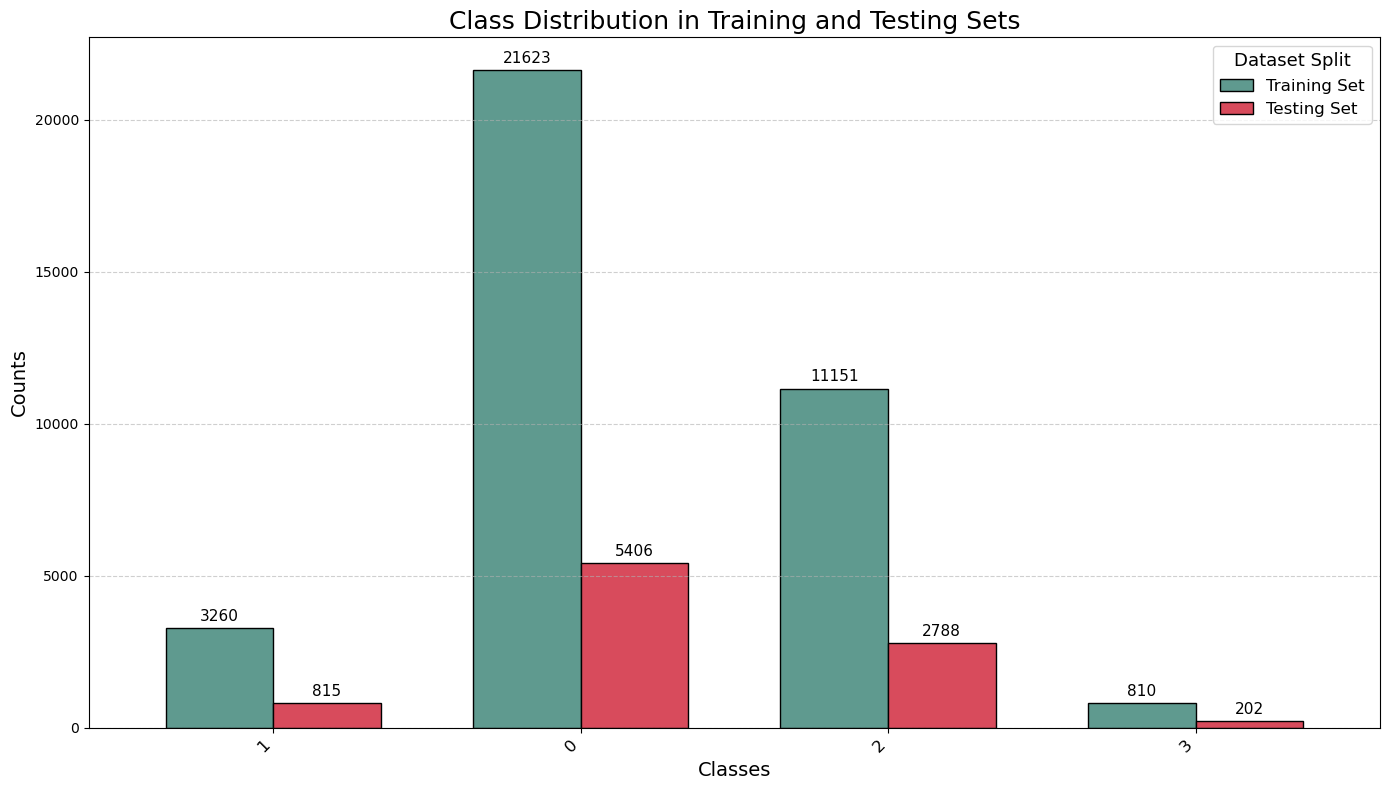

In [70]:
X = features_df.drop(columns=['label'])
y = features_df['label']

# Perform stratified splitting into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate class distribution for train and test sets
train_class_counts = y_train.value_counts().sort_index()
test_class_counts = y_test.value_counts().sort_index()

# Create DataFrame for class distribution comparison
class_counts_df = pd.DataFrame({
    'Training Set': train_class_counts,
    'Testing Set': test_class_counts
})

# Display the shape of the training and testing sets
print("Shape of Training Features (X_train):", X_train.shape)
print("Shape of Training Labels (y_train):", y_train.shape)
print("Shape of Testing Features (X_test):", X_test.shape)
print("Shape of Testing Labels (y_test):", y_test.shape)


class_names = y.unique()


plt.figure(figsize=(14, 8))
ax = class_counts_df.plot(kind='bar', color=['#5F9A8F', '#D84B5C'], edgecolor='black', width=0.7, ax=plt.gca())

# Set title and labels
plt.title('Class Distribution in Training and Testing Sets', fontsize=18)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)

plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(title='Dataset Split', fontsize=12, title_fontsize=13)


for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=11, padding=3)

plt.tight_layout()

# Show the plot
plt.show()


In [71]:
# Initialize the SVM classifiers with different kernels
svm_linear = SVC(kernel='linear', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)

# Train both models
svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)


SVC(random_state=42)

In [91]:

# Set the color palette
sns.set_palette("Set2")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Define Hyperparameters for SVM with Linear and RBF kernels
svm_linear_params = {
    'kernel': 'linear',
    'random_state': 42
}

svm_rbf_params = {
    'kernel': 'rbf',
    'random_state': 42
}

# Hyperparameter Tuning with GridSearchCV for both Linear and RBF SVMs
param_grid_linear = {
    'C': [0.1, 1, 10],  
    'gamma': ['scale', 'auto']  
}

param_grid_rbf = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

svm_linear = SVC(**svm_linear_params)
svm_rbf = SVC(**svm_rbf_params)

grid_search_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid_linear, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid_rbf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the models
grid_search_linear.fit(X_train_scaled, y_train)
grid_search_rbf.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_linear = grid_search_linear.best_params_
best_params_rbf = grid_search_rbf.best_params_

print(f"Best Hyperparameters for Linear SVM: {best_params_linear}")
print(f"Best Hyperparameters for RBF SVM: {best_params_rbf}")

# Train the final SVM models with the best hyperparameters
svm_linear_final = SVC(**best_params_linear, random_state=42)
svm_rbf_final = SVC(**best_params_rbf, random_state=42)

svm_linear_final.fit(X_train_scaled, y_train)
svm_rbf_final.fit(X_train_scaled, y_train)

# Step 5: Predict and Evaluate the Models
y_pred_linear = svm_linear_final.predict(X_test_scaled)
y_pred_rbf = svm_rbf_final.predict(X_test_scaled)

# Combine the predictions (majority voting)
combined_pred = np.round((y_pred_linear + y_pred_rbf) / 2)

# Evaluate metrics
accuracy = accuracy_score(y_test, combined_pred)
precision = precision_score(y_test, combined_pred, average='weighted')
recall = recall_score(y_test, combined_pred, average='weighted')
f1 = f1_score(y_test, combined_pred, average='weighted')


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, combined_pred))

# Display the metrics using tabulate
metrics = [
    ["Accuracy", f"{accuracy:.4f}"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1 Score", f"{f1:.4f}"],
]

print("\nMetrics Table:")
print(tabulate(metrics, headers=["Metric", "Score"], tablefmt="grid"))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, combined_pred)
labels = list(set(y_test)) 

confusion_matrix_table = [[""] + labels]
for i, row in enumerate(conf_matrix):
    confusion_matrix_table.append([labels[i]] + list(row))

print("\nConfusion Matrix:")
print(tabulate(confusion_matrix_table, tablefmt="grid"))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Hyperparameters for Linear SVM: {'C': 1, 'gamma': 'scale'}
Best Hyperparameters for RBF SVM: {'C': 10, 'gamma': 'scale'}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.40      0.51       815
           1       0.75      0.93      0.83      5406
           2       0.65      0.47      0.54      2788
           3       0.63      0.06      0.11       202

    accuracy                           0.72      9211
   macro avg       0.68      0.46      0.50      9211
weighted avg       0.71      0.72      0.70      9211


Metrics Table:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |  0.7236 |
+-----------+---------+
| Precision |  0.7113 |
+-----------+---------+
| Recall    |  0.7236 |
+-----------+---------+
| F1 Score  |  0.6986 |
+-----------+---------+

Confusion Matr

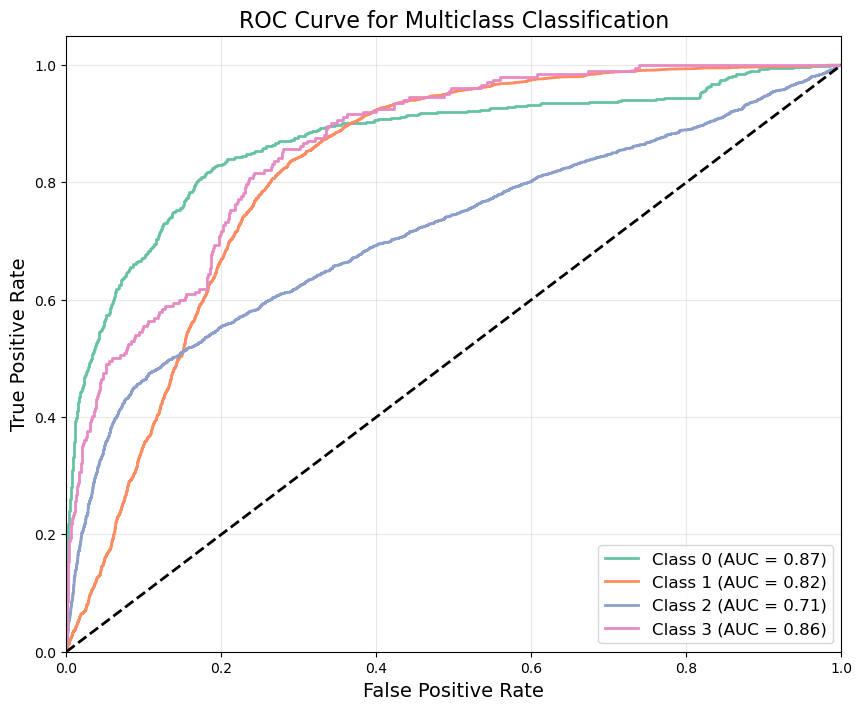

In [100]:

# Binarize the target labels
y_test_binarized = label_binarize(y_test, classes=list(set(y_test)))
n_classes = y_test_binarized.shape[1]

# Get decision function or probabilities from the model
y_score = svm_rbf_final.decision_function(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(sns.color_palette("Set2", n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Multiclass Classification', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [79]:

# Set the color palette
sns.set_palette("Set2")

# Step 1: LightGBM Dataset Preparation
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Step 2: Define Hyperparameters for LightGBM
params = {
    'objective': 'multiclass',  
    'num_class': len(set(y_train)),  # Number of classes for multiclass classification
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'metric': 'multi_logloss', 
    'verbose': -1  # Suppress logs
}

# Step 3: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [10, 15, 20]
}
lgb_model = lgb.LGBMClassifier(**params)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Use the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Merge the fixed params and the best_params from GridSearchCV
final_params = {**params, **best_params}

# Step 4: Train the final LightGBM model with the best hyperparameters
best_lgb = lgb.LGBMClassifier(**final_params)
best_lgb.fit(X_train, y_train)

# Step 5: Predict and Evaluate the Model
y_pred = best_lgb.predict(X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, best_lgb.predict_proba(X_test), multi_class='ovr', average='weighted')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the metrics using tabulate
metrics = [
    ["Accuracy", f"{accuracy:.4f}"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1 Score", f"{f1:.4f}"],
]

print("\nMetrics Table:")
print(tabulate(metrics, headers=["Metric", "Score"], tablefmt="grid"))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
labels = list(set(y_test))  

confusion_matrix_table = [[""] + labels]
for i, row in enumerate(conf_matrix):
    confusion_matrix_table.append([labels[i]] + list(row))

print("\nConfusion Matrix:")
print(tabulate(confusion_matrix_table, tablefmt="grid"))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 63}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.60       815
           1       0.79      0.93      0.85      5406
           2       0.71      0.54      0.61      2788
           3       0.42      0.20      0.27       202

    accuracy                           0.76      9211
   macro avg       0.66      0.55      0.59      9211
weighted avg       0.75      0.76      0.74      9211


Metrics Table:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |  0.7595 |
+-----------+---------+
| Precision |  0.7478 |
+-----------+---------+
| Recall    |  0.7595 |
+-----------+---------+
| F1 Score  |  0.7448 |
+-----------+---------+

Confusion Matrix:
+---+-----+------+------+----+
|   |   0 |    1 |    2 |  3 |
+---+-----+------+------+----+
| 0 | 42

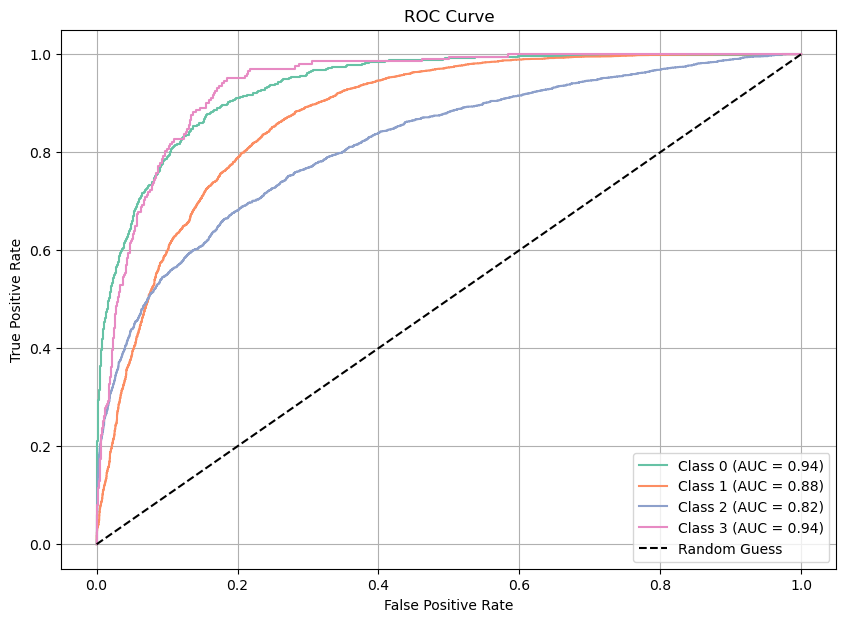

In [82]:
y_test_bin = label_binarize(y_test, classes=range(len(set(y_test))))
y_pred_prob = best_lgb.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(set(y_test))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add labels and legend
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [95]:

# Reshape input data for CNN 
X_train_cnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(-1, X_test.shape[1], 1)

# Convert labels to categorical if multi-class
if len(np.unique(y_train)) > 2:
    y_train_cnn = tf.keras.utils.to_categorical(y_train)
    y_test_cnn = tf.keras.utils.to_categorical(y_test)
    output_units = y_train_cnn.shape[1]
    activation = 'softmax'
else:
    y_train_cnn = y_train
    y_test_cnn = y_test
    output_units = 1
    activation = 'sigmoid'

# Build the CNN model
cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy' if len(np.unique(y_train)) > 2 else 'binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on the test set
y_pred_cnn = cnn.predict(X_test_cnn)
if len(np.unique(y_train)) > 2:
    y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
else:
    y_pred_cnn_classes = (y_pred_cnn > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_cnn_classes)
precision = precision_score(y_test, y_pred_cnn_classes, average='weighted')
recall = recall_score(y_test, y_pred_cnn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_cnn_classes, average='weighted')
# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cnn_classes))
# Display metrics in a tabular format
metrics_table = [["Metric", "Value"],
                 ["Accuracy", f"{accuracy:.4f}"],
                 ["Precision", f"{precision:.4f}"],
                 ["Recall", f"{recall:.4f}"],
                 ["F1 Score", f"{f1:.4f}"]]
print("\nModel Performance Metrics:")
print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_cnn_classes)

# Display Confusion Matrix in tabular format
labels = sorted(np.unique(y_test))
conf_matrix_table = [[""] + [f"Predicted {label}" for label in labels]]
for i, row in enumerate(conf_matrix):
    conf_matrix_table.append([f"Actual {labels[i]}"] + list(row))

print("\nConfusion Matrix:")
print(tabulate(conf_matrix_table, headers="firstrow", tablefmt="grid"))


Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5900 - loss: 0.9852 - val_accuracy: 0.6359 - val_loss: 0.8318
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6405 - loss: 0.8373 - val_accuracy: 0.6423 - val_loss: 0.8173
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6414 - loss: 0.8276 - val_accuracy: 0.6523 - val_loss: 0.7876
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6561 - loss: 0.7913 - val_accuracy: 0.6607 - val_loss: 0.7709
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6656 - loss: 0.7804 - val_accuracy: 0.6765 - val_loss: 0.7492
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6782 - loss: 0.7590 - val_accuracy: 0.6915 - val_loss: 0.7278
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6904 - loss: 0.7379 - val_accuracy: 0.6941 - val_loss: 0.7144
Epoch 8/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6980 - loss: 0.7306 - val_accurac

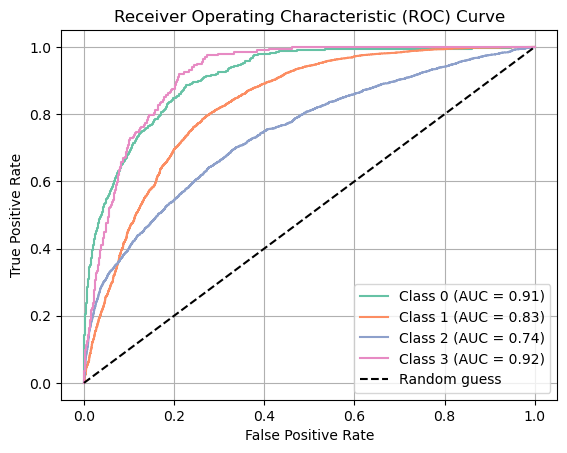

In [96]:
# Calculate ROC curve and AUC value
if len(np.unique(y_train)) > 2:  # Multi-class ROC-AUC
    y_test_prob = y_test_cnn
    y_pred_prob = y_pred_cnn
    roc_auc = {}
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(y_test_prob[:, i], y_pred_prob[:, i])
        roc_auc[labels[i]] = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {labels[i]} (AUC = {roc_auc[labels[i]]:.2f})")
else:  # Binary ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_cnn)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [89]:
# Define the parameter grid for SVM models
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize and fit SVM model using GridSearchCV
svm_model = svm.SVC()
svm_grid_search = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [10, 20, 30]
}

# Initialize and fit LightGBM model using GridSearchCV
lgb_model = lgb.LGBMClassifier()
lgb_grid_search = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='accuracy')
lgb_grid_search.fit(X_train, y_train)
best_lgb_model = lgb_grid_search.best_estimator_

best_svm_linear = best_svm_model.fit(X_train, y_train)
best_svm_rbf = best_svm_model.fit(X_train, y_train)
best_lgb_model.fit(X_train, y_train)

# Get predictions from tuned models
svm_linear_pred_tuned = best_svm_linear.predict(X_test)
svm_rbf_pred_tuned = best_svm_rbf.predict(X_test)
lightgbm_pred_tuned = best_lgb_model.predict(X_test)

weights = {'svm_linear': 0.1, 'svm_rbf': 0.1, 'lightgbm': 0.8}

hybrid_pred_tuned = np.round(
    (weights['svm_linear'] * svm_linear_pred_tuned +
     weights['svm_rbf'] * svm_rbf_pred_tuned +
     weights['lightgbm'] * lightgbm_pred_tuned) / sum(weights.values())
).astype(int)

accuracy_tuned = accuracy_score(y_test, hybrid_pred_tuned)
precision_tuned = precision_score(y_test, hybrid_pred_tuned, average='weighted')
recall_tuned = recall_score(y_test, hybrid_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, hybrid_pred_tuned, average='weighted')

# Print Classification Report for Hybrid Model with tuned parameters
print("\nClassification Report for Tuned Hybrid Model:")
print(classification_report(y_test, hybrid_pred_tuned))

# Display Metrics Table for Tuned Hybrid Model
metrics_tuned = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned]
}
metrics_df_tuned = pd.DataFrame(metrics_tuned)
print("\nTuned Metrics Table:")
print(tabulate(metrics_df_tuned, headers='keys', tablefmt='grid', showindex=False))

# Confusion Matrix Visualization for Tuned Model
def display_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    labels = sorted(list(set(y_test)))  

    # Add row/column labels for visualization
    conf_matrix_table = [[""] + labels]
    for i, row in enumerate(conf_matrix):
        conf_matrix_table.append([labels[i]] + list(row))

    print("\nConfusion Matrix:")
    print(tabulate(conf_matrix_table, headers="firstrow", tablefmt="grid"))

display_confusion_matrix(y_test, hybrid_pred_tuned)



Classification Report for Tuned Hybrid Model:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61       815
           1       0.79      0.93      0.85      5406
           2       0.71      0.55      0.62      2788
           3       0.42      0.17      0.24       202

    accuracy                           0.76      9211
   macro avg       0.66      0.55      0.58      9211
weighted avg       0.75      0.76      0.75      9211


Tuned Metrics Table:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.761589 |
+-----------+----------+
| Precision | 0.749401 |
+-----------+----------+
| Recall    | 0.761589 |
+-----------+----------+
| F1 Score  | 0.747099 |
+-----------+----------+

Confusion Matrix:
+----+-----+------+------+-----+
|    |   0 |    1 |    2 |   3 |
+====+=====+======+======+=====+
|  0 | 441 |  141 |  224 |   9 |
+----+-----+------+------+-----+
|  1 |  35 | 5010 |  344 |  17 |
+---

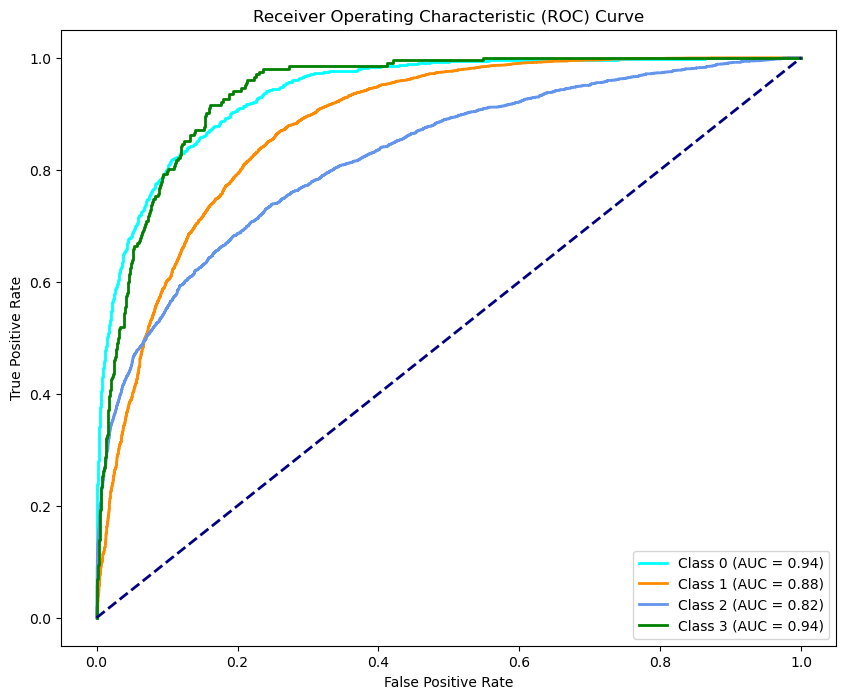

In [109]:
# Binarize the output for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = best_lgb_model.predict_proba(X_test)  # Get class probabilities

# For each class, compute ROC curve and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])  # Adjust color cycle based on number of classes

for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [106]:
# Performance metrics for the models
data = {
    'Model': ['Dual SVM (Linear + RBF)', 'LightGBM', 'CNN', 'Hybrid (SVM + LightGBM)'],
    'Accuracy': [0.7236, 0.7595 ,  0.7054 ,  0.7615],
    'Precision': [0.7113,   0.7478, 0.6801 , 0.7494],
    'Recall': [0.7236,   0.7595,   0.7054, 0.7615],
    'F1 Score': [0.6986, 0.7448, 0.6678,  0.7470]
}

# Create a DataFrame
df_metrics = pd.DataFrame(data)

# Display the table without colors
print("\nComparison Table:")
print(tabulate(df_metrics, headers='keys', tablefmt='grid', showindex=False))





Comparison Table:
+-------------------------+------------+-------------+----------+------------+
| Model                   |   Accuracy |   Precision |   Recall |   F1 Score |
+=========================+============+=============+==========+============+
| Dual SVM (Linear + RBF) |     0.7236 |      0.7113 |   0.7236 |     0.6986 |
+-------------------------+------------+-------------+----------+------------+
| LightGBM                |     0.7595 |      0.7478 |   0.7595 |     0.7448 |
+-------------------------+------------+-------------+----------+------------+
| CNN                     |     0.7054 |      0.6801 |   0.7054 |     0.6678 |
+-------------------------+------------+-------------+----------+------------+
| Hybrid (SVM + LightGBM) |     0.7615 |      0.7494 |   0.7615 |     0.747  |
+-------------------------+------------+-------------+----------+------------+


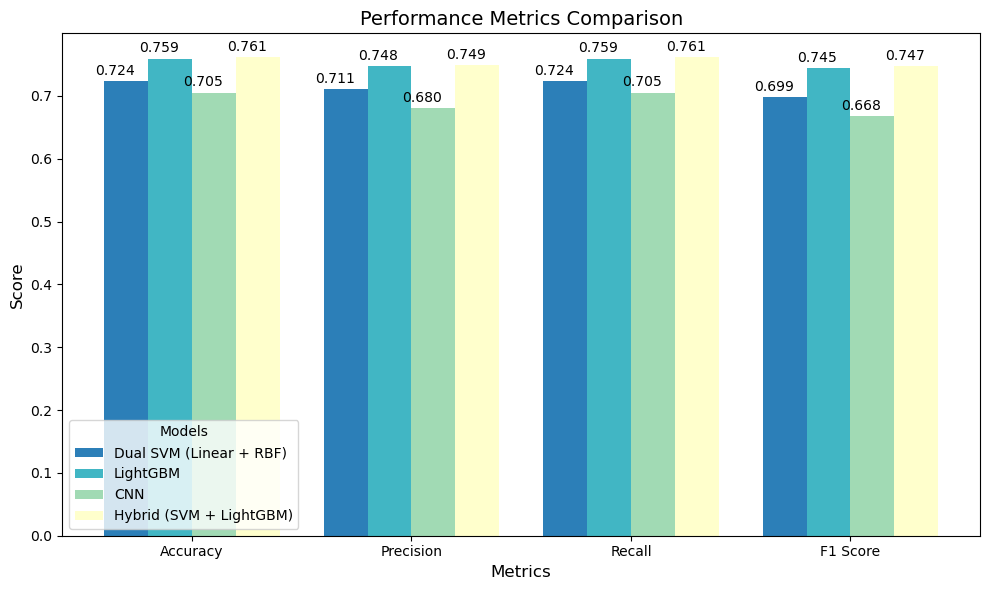

In [105]:
# Plot the performance metrics as a grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#2C7FB8', '#41B6C4', '#A1DAB4', '#FFFFCC']  # Color palette

x = range(len(metrics))  # X-axis positions
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(data['Model']):
    y_values = [data[metric][i] for metric in metrics]
    ax.bar([pos + width * i for pos in x], y_values, width=width, label=model, color=colors[i % len(colors)])

# Add labels and title
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics Comparison', fontsize=14)
ax.set_xticks([pos + width * 1.5 for pos in x])
ax.set_xticklabels(metrics)
ax.legend(title='Models', fontsize=10)

# Annotate the bars with values
for i, model in enumerate(data['Model']):
    y_values = [data[metric][i] for metric in metrics]
    for j, value in enumerate(y_values):
        ax.text(j + width * i - 0.05, value + 0.005, f"{value:.3f}", fontsize=10, ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()
